## COSC274 Homework 4
### Gibran Erlangga / F004QXJ

### Naive Bayes Classifier

In [1]:
# Import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('hw4_naive.csv')
df.head()

Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  Label
0    7430.14    9529.78   -2453.33         19        123        621      0
1   11256.40   50455.10   -4220.00         18        216       2677      0
2   13093.00   51897.10   -2880.00         30        234       2464      0
3   14303.00  102632.00   -5702.20        144        281       4061      1
4   14688.00   83343.40   -2430.00         52        223       2822      1

1) (5 points) Divide the data into test / train sets (80% and 20% respectively)

In [2]:
# since its tricky to implement multinomial NB on continuous data, I will convert the continuous data into bins
target = 'Label'
y = df[target]
x = df.drop(target, axis=1)

x_bins = pd.DataFrame()
n_bin = 5

for i in x:
    new_col_name = i + "_binned"
    x_bins[new_col_name] = pd.qcut(x[i], q=n_bin, labels=[i+1 for i in range(n_bin)])

In [3]:
from sklearn.model_selection import train_test_split

# train-test split after binning
x_train, x_test, y_train, y_test = train_test_split(x_bins, y, test_size=0.2)

2) (25 points) Implement a Multinomial Naïve Bayes classifier **from scratch**, with smoothing (you can set the default smoothing value to 1). You are free to code this up however you like, however, make sure that there is a function that can be called with a test X vector and returns the predicted Y.

In [4]:
class MultinomialNB_scratch:
    
    def fit(self, x, y, smoothing_value = 1):
        n_row, n_col = x.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        # get max number of categories of all available features
        n_cat = max([x_bins[i].nunique() for i in x_bins])
        
        self.features_proba = np.zeros((n_classes, n_cat, n_col), dtype=np.float64)
        self.prior = np.zeros(n_classes, dtype=np.float64)
        
        for c in self.classes:
            x_c = x[y == c]
            # calculate prior
            self.prior[c] = len(x_c)/ len(x)
            # calculate likelihood
            for idx, var in enumerate(x_c):
                self.features_proba[c, :, idx] = x_c[var].value_counts(normalize=True).sort_index()
        
        # apply smoothing to avoid the zero problem, using laplace (alpha = 1) or lidstone (alpha < 1) smoothing
    
    def predict(self, x):
        y_pred = [self._predict(i) for i in x.to_numpy()]
        return y_pred
    
    def _predict(self, x):
        posteriors = []
        
        for idx, c in enumerate(self.classes):
            posterior_c = self.prior[idx] * self._features_proba(idx, x)
            posteriors.append(posterior_c)
        return self.classes[np.argmax(posteriors)]
    
    def _features_proba(self, class_idx, x):
        var_proba = []
        
        for idx, val in enumerate(x):
            proba = self.features_proba[class_idx, val-1, idx]
            var_proba.append(proba)
        
        return np.prod(var_proba)

In [5]:
multinomNB = MultinomialNB_scratch()
multinomNB.fit(x_train, y_train, smoothing_value=1)
y_pred_multi = multinomNB.predict(x_test)

In [6]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(x_train, y_train)
y_pred_multi_sklearn = nb.predict(x_test)

/Users/gibranerlangga/opt/miniconda3/envs/cosc274/lib/python3.9/site-packages/sklearn/utils/validation.py:964: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(
/Users/gibranerlangga/opt/miniconda3/envs/cosc274/lib/python3.9/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


3) (25 points) Implement a Gaussian Naïve Bayes classier **from scratch** (no need for smoothing here).

In [7]:
target = 'Label'
y = df[target]
x = df.drop(target, axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [8]:
# gaussian naive bayes classifier
class GaussianNB_scratch:
    
    def fit(self, x, y):
        n_row, n_col = x.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        
        self.mean = np.zeros((n_classes, n_col), dtype=np.float64)
        self.std = np.zeros((n_classes, n_col), dtype=np.float64)
        self.prior = np.zeros(n_classes, dtype=np.float64)

#         for num, c in enumerate(self.classes):
        for c in self.classes:
            x_class = x[y == c]
            self.mean[c,:] = x_class.mean()
            self.std[c,:] = x_class.std()
            self.prior[c] = len(x_class)/ len(x)
            
    def predict(self, x):
        y_pred = [self._predict(i) for i in x.to_numpy()]
        return y_pred
    
    def _predict(self, x):
        posteriors = []
        
        for idx, c in enumerate(self.classes):
            # apply log to avoid floating point errors
            prior_c = np.log(self.prior[idx])
            class_cond_c = np.sum(np.log(self._pdf(idx, x)))
            posterior_c = class_cond_c + prior_c
            posteriors.append(posterior_c)
            
        return self.classes[np.argmax(posteriors)]
            
    def _pdf(self, class_idx, x):
        mean = self.mean[class_idx]
        std = self.std[class_idx]
        numerator = np.exp(-1*(x-mean)**2 / (2*std**2))
        denominator = np.sqrt(2*np.pi*std**2)
        return numerator/denominator

In [9]:
# validation using sklearn
from sklearn.naive_bayes import GaussianNB

gaussian_nb = GaussianNB_scratch()
gaussian_nb.fit(x_train, y_train)
y_pred_gauss = gaussian_nb.predict(x_test)

gaussian_nb_sklearn = GaussianNB()
gaussian_nb_sklearn.fit(x_train, y_train)
y_pred_gauss_sklearn = gaussian_nb.predict(x_test)

4) (10 points) Calculate the accuracy and the F1 score of test data using both of your models implemented above.

In [10]:
from sklearn.metrics import accuracy_score, f1_score

accuracy_scratch = accuracy_score(y_test, y_pred_multi)
accuracy_sklearn = accuracy_score(y_test, y_pred_multi_sklearn)

f1 = f1_score(y_test, y_pred_multi)
f1_sklearn = f1_score(y_test, y_pred_multi_sklearn)

print('Multinomial Naive Bayes')
print(accuracy_scratch, accuracy_sklearn)
print(f1, f1_sklearn)

Multinomial Naive Bayes
0.5348214285714286 0.5410714285714285
0.4306010928961749 0.43141592920353977


In [11]:
accuracy_scratch = accuracy_score(y_test, y_pred_gauss)
accuracy_sklearn = accuracy_score(y_test, y_pred_gauss_sklearn)

f1 = f1_score(y_test, y_pred_gauss)
f1_sklearn = f1_score(y_test, y_pred_gauss_sklearn)

print('Gaussian Naive Bayes')
print(accuracy_scratch, accuracy_sklearn)
print(f1, f1_sklearn)

Gaussian Naive Bayes
0.60625 0.60625
0.3287671232876712 0.3287671232876712


### Bonus: K-means Clustering

1) (35 points) Implement a generalized K-means/median algorithm. You should have a single function that takes in as input the data points, K, and some other hyperparameters, specified below. The function should return K sets of data points. Each set corresponding to one cluster.

The hyperparameters your functions should support and the values they can take are:
- The method for calculating the centroid: Means or Median
- The initialization method: Random Split Initialization or Random Seed Selection Method
- Max_iter: max number of iterations to run the algorithm. 
- K: number of clusters

Note that your stopping condition should have two parts: 
- stop if you reach the max iterations
- stop if no change is made to the clusters in the last step.

You will be running this code in question 3 of the assignment. For this part you just need to implement the function.

In [12]:
# import data
df_cluster = pd.read_csv('hw4_cluster.csv')
df_cluster.head(3)

x1        x2
0 -0.201517 -0.683358
1  0.374519 -0.828082
2 -0.161895 -1.247107

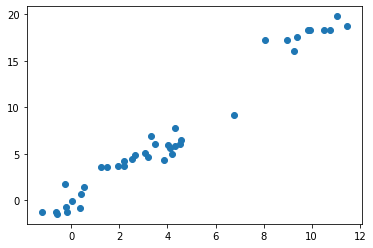

In [13]:
plt.scatter(df_cluster.x1, df_cluster.x2)

In [14]:
# initialize cluster centers
def k_means(data, k, method, init_method, max_iter):
    pass

2) (15 points) SSE score.
In this part of the assignment, you are implementing a function that calculates the SSE for a list of clusters. The function should take in a list of clusters (such as the output of the last function you implemented) and return a single SSE score.

3) (15 points) Finding best K.

Run the code you implemented in question 1 for k=2,3,4,5. Set the other hyperparameters to the following:
- The method for calculating the centroid: Mean
- The initialization method: Random Split Initialization 
- Max_iterations: 100

Calculate the SSE for each K using the function in question 2 and use these scores to pick the best K. What is the best K?